In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from apyori import apriori

In [146]:
# Step 1: Data Collection
df = pd.read_excel('data/online_retail_II.xlsx')
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [147]:
df.columns

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')

In [148]:
df.Country.unique()

array(['United Kingdom', 'France', 'USA', 'Belgium', 'Australia', 'EIRE',
       'Germany', 'Portugal', 'Japan', 'Denmark', 'Nigeria',
       'Netherlands', 'Poland', 'Spain', 'Channel Islands', 'Italy',
       'Cyprus', 'Greece', 'Norway', 'Austria', 'Sweden',
       'United Arab Emirates', 'Finland', 'Switzerland', 'Unspecified',
       'Malta', 'Bahrain', 'RSA', 'Bermuda', 'Hong Kong', 'Singapore',
       'Thailand', 'Israel', 'Lithuania', 'West Indies', 'Lebanon',
       'Korea', 'Brazil', 'Canada', 'Iceland'], dtype=object)

In [149]:
# Print the total number of transactions (rows)
print("\nTotal number of transactions (rows):", len(df))


Total number of transactions (rows): 525461


In [150]:
# Print the number of unique items (assuming 'Description' is the item column)
unique_items = df['Description'].nunique()
print("\nNumber of unique items:", unique_items)


Number of unique items: 4681


In [151]:
# Select only the records from the specified countries
selected_countries = ['United Kingdom', 'France', 'USA']
df_filtered = df[df['Country'].isin(selected_countries)]
# Print the filtered records
print("Filtered Records for the Selected Countries:")
print(df_filtered)

Filtered Records for the Selected Countries:
       Invoice StockCode                          Description  Quantity  \
0       489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1       489434    79323P                   PINK CHERRY LIGHTS        12   
2       489434    79323W                  WHITE CHERRY LIGHTS        12   
3       489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4       489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   
...        ...       ...                                  ...       ...   
525456  538171     22271                 FELTCRAFT DOLL ROSIE         2   
525457  538171     22750         FELTCRAFT PRINCESS LOLA DOLL         1   
525458  538171     22751       FELTCRAFT PRINCESS OLIVIA DOLL         1   
525459  538171     20970   PINK FLORAL FELTCRAFT SHOULDER BAG         2   
525460  538171     21931               JUMBO STORAGE BAG SUKI         2   

               InvoiceDate  Price  Customer ID        

In [152]:
# First, group by 'Country' and count the number of unique invoices
country_avg = df_filtered.groupby('Country')['Invoice'].nunique().reset_index(name='Total_Invoices')

# Then, group by 'Country' and calculate the number of items in each transaction
# We will count the unique items per invoice for each country
items_per_country = df_filtered.groupby('Country')['Description'].apply(lambda x: x.nunique()).reset_index(name='Total_Items')

# Now, merge the two dataframes to calculate the average items per invoice for each country
country_avg = pd.merge(country_avg, items_per_country, on='Country')

# Calculate the average number of items per invoice for each country
country_avg['Avg_Items_Per_Invoice'] = country_avg['Total_Items'] / country_avg['Total_Invoices']

# Print the average number of items per transaction for each country
print("======> Average Items per Country <======")
print(country_avg[['Country', 'Avg_Items_Per_Invoice']])

======> Average Items per Country <======
          Country  Avg_Items_Per_Invoice
0          France               4.808081
1             USA               9.166667
2  United Kingdom               0.174858


In [153]:
# Step 2: Data processing

# drop missing values
missing_data = df.dropna(subset=["Description","StockCode","Invoice"])

# remove stockCodes which start with 'C'
rm_data = missing_data[~missing_data['StockCode'].astype(str).str.startswith('C')]
transactions = rm_data.groupby('Invoice')['Description'].apply(list).values

# convert transactions to list and remove duplicates
transaction_list = [list(set(transaction)) for transaction in transactions]
print(f"======> Total Transactions: {len(transaction_list)} rows  <======", )

# find with 7 records
transaction_limit = transaction_list[:7]

unique_item_transactions = [item for transaction in transaction_limit for item in transaction]
count = len(unique_item_transactions)
print(f"======> Unique item transactions: {count} <======")

print("======> Items <======")
for transaction in transaction_limit:
    print(f"Transaction: {transaction}, Length: {len(transaction)}")

======> Total Transactions: 25880 rows  <======
======> Unique item transactions: 92 <======
======> Items <======
Transaction: ['PINK CHERRY LIGHTS', '15CM CHRISTMAS GLASS BALL 20 LIGHTS', 'STRAWBERRY CERAMIC TRINKET BOX', 'RECORD FRAME 7" SINGLE SIZE ', 'SAVE THE PLANET MUG', ' WHITE CHERRY LIGHTS', 'FANCY FONT HOME SWEET HOME DOORMAT', 'PINK DOUGHNUT TRINKET POT '], Length: 8
Transaction: ['CAT BOWL ', 'HEART MEASURING SPOONS LARGE', 'LUNCHBOX WITH CUTLERY FAIRY CAKES ', 'DOG BOWL , CHASING BALL DESIGN'], Length: 4
Transaction: ['SMALL MARSHMALLOWS PINK BOWL', ' PEACE WOODEN BLOCK LETTERS', 'BISCUITS SMALL BOWL LIGHT BLUE', 'HEART IVORY TRELLIS LARGE', 'HEART FILIGREE DOVE LARGE', 'PLEASE ONE PERSON  METAL SIGN', 'BATH BUILDING BLOCK WORD', 'CLASSIC WHITE FRAME', 'SET OF 3 BLACK FLYING DUCKS', 'AREA PATROLLED METAL SIGN', 'HOME BUILDING BLOCK WORD', 'SCOTTIE DOG HOT WATER BOTTLE', 'CHRISTMAS CRAFT WHITE FAIRY ', 'DOOR MAT BLACK FLOCK ', 'PIZZA PLATE IN BOX', 'LOVE BUILDING BLOCK WOR

In [154]:
# Ensure the 'Description' is stripped of extra spaces
df['Description'] = df['Description'].str.strip()

# Drop rows without invoice numbers
df.dropna(axis=0, subset=['Invoice'], inplace=True)
df['Invoice'] = df['Invoice'].astype('str')

# Drop all transactions done on credit (InvoiceNo contains 'C')
df = df[~df['Invoice'].str.contains('C')]

# Select only the relevant countries (France, UK, USA)
selected_countries = ['United Kingdom', 'France', 'USA']
df_filtered = df[df['Country'].isin(selected_countries)]

# Show filtered dataframe
df_filtered.head()


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [155]:
# Create baskets for France, UK, and USA based on the selected countries
basket_France = (df_filtered[df_filtered['Country'] == "France"]
                 .groupby(['Invoice', 'Description'])['Quantity']
                 .sum().unstack().reset_index().fillna(0)
                 .set_index('Invoice'))

basket_UK = (df_filtered[df_filtered['Country'] == "United Kingdom"]
             .groupby(['Invoice', 'Description'])['Quantity']
             .sum().unstack().reset_index().fillna(0)
             .set_index('Invoice'))

basket_USA = (df_filtered[df_filtered['Country'] == "USA"]
              .groupby(['Invoice', 'Description'])['Quantity']
              .sum().unstack().reset_index().fillna(0)
              .set_index('Invoice'))

# Show baskets for each country
print("======> France Transactions <======")
display(basket_France.head())

print("======> UK Transactions <======")
display(basket_UK.head())

print("======> USA Transactions <======")
display(basket_USA.head())


======> France Transactions <======


Description,10 COLOUR SPACEBOY PEN,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE POSY,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE RED SPOTTY,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,...,WRAP PINK FAIRY CAKES,WRAP RED APPLES,WRAP SUKI AND FRIENDS,WRAP WINTER FOREST,"WRAP, CAROUSEL",YELLOW BREAKFAST CUP AND SAUCER,YELLOW RED FLOWER PIGGY BANK,YOU'RE CONFUSING ME METAL SIGN,ZINC METAL HEART DECORATION,ZINC WILLIE WINKIE CANDLE STICK
Invoice,,,,,,,,,,,,,,,,,,,,,
489439,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
489557,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0
489883,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
490139,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
490152,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


======> UK Transactions <======


Description,*Boombox Ipod Classic,*USB Office Glitter Lamp,*USB Office Mirror Ball,10 COLOUR SPACEBOY PEN,11 PC CERAMIC TEA SET POLKADOT,12 ASS ZINC CHRISTMAS DECORATIONS,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 IVORY ROSE PEG PLACE SETTINGS,...,wet & rotting,wet and rotting,wet cartons,wet ctn,wet damages,wet/smashed/unsellable,wonky bottom/broken,wrong code,wrong ctn size,wrong invc
Invoice,,,,,,,,,,,,,,,,,,,,,
489434,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
489435,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
489436,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
489437,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
489438,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


======> USA Transactions <======


Description,36 DOILIES SPACEBOY DESIGN,5 HOOK HANGER MAGIC TOADSTOOL,5 HOOK HANGER RED MAGIC TOADSTOOL,60 CAKE CASES DOLLY GIRL DESIGN,60 TEATIME FAIRY CAKE CASES,72 ROUND PINK DOILIES,72 SWEETHEART FAIRY CAKE CASES,AIRLINE BAG VINTAGE WORLD CHAMPION,BAKING SET 9 PIECE RETROSPOT,BASKET OF TOADSTOOLS,...,VINTAGE BLUE TINSEL REEL,VINTAGE GOLD TINSEL REEL,VINTAGE HEADS AND TAILS CARD GAME,VINTAGE UNION JACK BUNTING,VINTAGE UNION JACK SHOPPING BAG,WOOD STAMP SET BEST WISHES,WOODLAND DESIGN COTTON TOTE BAG,WRAP CHRISTMAS VILLAGE,WRAP I LOVE LONDON,WRAP WEDDING DAY
Invoice,,,,,,,,,,,,,,,,,,,,,
489444,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
494110,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,12.0,...,24.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
494113,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
494234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
494891,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,6.0,0.0,...,0.0,0.0,0.0,4.0,0.0,2.0,4.0,0.0,0.0,0.0


In [156]:
# Convert baskets to lists of items (for transaction encoding)
transactions_France = basket_France.apply(lambda x: [str(i) for i in x[x > 0].index], axis=1).values
transactions_UK = basket_UK.apply(lambda x: [str(i) for i in x[x > 0].index], axis=1).values
transactions_USA = basket_USA.apply(lambda x: [str(i) for i in x[x > 0].index], axis=1).values

# Combine transactions for the three countries
transactions_combined = list(transactions_France) + list(transactions_UK) + list(transactions_USA)

# Show the first few combined transactions
print("======> Combined Transactions <======")
transactions_combined[:5]  # Show first 5 transactions


======> Combined Transactions <======


[['ASSORTED CAKES FRIDGE MAGNETS',
  'ASSORTED COLOUR MINI CASES',
  'BAKING SET 9 PIECE RETROSPOT',
  'BLACK/BLUE DOTS RUFFLED UMBRELLA',
  'CHRISTMAS PUDDING TRINKET POT',
  'LUNCHBOX WITH CUTLERY RETROSPOT',
  'PACK 20 DOLLY PEGS',
  'PARTY CONE CHRISTMAS DECORATION',
  'PINK DOUGHNUT TRINKET POT',
  'POSTAGE',
  'RED TOADSTOOL LED NIGHT LIGHT',
  'RED/WHITE DOTS RUFFLED UMBRELLA',
  'RETRO SPORT PARTY BAG + STICKER SET',
  'RETRO SPOT TEA SET CERAMIC 11 PC',
  'SET OF THREE VINTAGE GIFT WRAPS',
  'SET/3 RUSSIAN DOLL STACKING TINS',
  'VINTAGE DESIGN GIFT TAGS',
  'WRAP BLUE RUSSIAN FOLKART',
  'WRAP ENGLISH ROSE'],
 ['BASKET OF TOADSTOOLS',
  'JUMBO BAG RED WHITE SPOTTY',
  'JUMBO BAG TOYS',
  'JUMBO BAG WOODLAND ANIMALS',
  'LUNCHBOX WITH CUTLERY FAIRY CAKES',
  'LUNCHBOX WITH CUTLERY RETROSPOT',
  'PACK OF 72 RETRO SPOT CAKE CASES',
  'POSTAGE',
  'RED BIRD HOUSE TREE DECORATION',
  'RED SPOTTY CHILDS UMBRELLA',
  'RED SPOTTY COIR DOORMAT',
  'RED SPOTTY CUP',
  'RED SPOTTY SHOPP

In [157]:
# Use TransactionEncoder to transform the data into a binary matrix
tranEncoder = TransactionEncoder()
tranEncoderArray = tranEncoder.fit(transactions_combined).transform(transactions_combined)
binary_matrix = pd.DataFrame(tranEncoderArray, columns=tranEncoder.columns_)

# Print the binary matrix
print("======> Binary Matrix for France, UK, and USA <======")
display(binary_matrix.astype(int))  # Display binary matrix as integers


======> Binary Matrix for France, UK, and USA <======


,*Boombox Ipod Classic,*USB Office Glitter Lamp,*USB Office Mirror Ball,10 COLOUR SPACEBOY PEN,11 PC CERAMIC TEA SET POLKADOT,12 ASS ZINC CHRISTMAS DECORATIONS,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 IVORY ROSE PEG PLACE SETTINGS,...,dotcom email,eurobargain invc/credit,found,found again,mailout,mailout addition,temp,tk maxx mix up with pink,update,wrong invc
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19883,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19884,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19885,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19886,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [158]:
# Debugging: Print a sample of the transaction_list
print("Sample transactions before apriori:")
for t in transaction_list[:5]:  # Print the first 5 transactions
    print(t)

Sample transactions before apriori:
['PINK CHERRY LIGHTS', '15CM CHRISTMAS GLASS BALL 20 LIGHTS', 'STRAWBERRY CERAMIC TRINKET BOX', 'RECORD FRAME 7" SINGLE SIZE ', 'SAVE THE PLANET MUG', ' WHITE CHERRY LIGHTS', 'FANCY FONT HOME SWEET HOME DOORMAT', 'PINK DOUGHNUT TRINKET POT ']
['CAT BOWL ', 'HEART MEASURING SPOONS LARGE', 'LUNCHBOX WITH CUTLERY FAIRY CAKES ', 'DOG BOWL , CHASING BALL DESIGN']
['SMALL MARSHMALLOWS PINK BOWL', ' PEACE WOODEN BLOCK LETTERS', 'BISCUITS SMALL BOWL LIGHT BLUE', 'HEART IVORY TRELLIS LARGE', 'HEART FILIGREE DOVE LARGE', 'PLEASE ONE PERSON  METAL SIGN', 'BATH BUILDING BLOCK WORD', 'CLASSIC WHITE FRAME', 'SET OF 3 BLACK FLYING DUCKS', 'AREA PATROLLED METAL SIGN', 'HOME BUILDING BLOCK WORD', 'SCOTTIE DOG HOT WATER BOTTLE', 'CHRISTMAS CRAFT WHITE FAIRY ', 'DOOR MAT BLACK FLOCK ', 'PIZZA PLATE IN BOX', 'LOVE BUILDING BLOCK WORD', 'ASSORTED COLOUR BIRD ORNAMENT', 'FULL ENGLISH BREAKFAST PLATE', 'BLACK DINER WALL CLOCK']
['CHRISTMAS CRAFT HEART STOCKING ', 'BLUE PAD

In [159]:
#step4: Frequent One Itemset Generation (Transaction Creation)
transactions = df.groupby('Invoice')['Description'].apply(list).values
transaction_list = [list(set(transaction)) for transaction in transactions]
print("Total transactions:", len(transaction_list))

Total transactions: 24224


In [160]:
#step5: Remove Duplicate Data and Generating RC
transaction_list = [[str(item) for item in set(transaction)] for transaction in transactions]


In [161]:
#step6: Automatic Find Actual Minimum Support
min_support = 0.02
min_confidence = 0.3
min_lift = 1.0


In [162]:
#step7: Generate Frequent Itemset
# Run the Apriori algorithm
rules = apriori(transaction_list, min_support=min_support, 
                min_confidence=min_confidence, min_lift=min_lift)

# Convert results to a list for readability
results = list(rules)
print("Total rules generated:", len(results))

Total rules generated: 12


In [163]:
# Step 8: Association Rule
print("\n=== Association Rules ===")
for rule in results:
    items = [x for x in rule.items]
    print(f"Rule: {items}")
    print(f"Support: {rule.support:.4f}")
    for ordered_stat in rule.ordered_statistics:
        print(f"Confidence: {ordered_stat.confidence:.4f}")
        print(f"Lift: {ordered_stat.lift:.4f}")
    print("-" * 30)



=== Association Rules ===
Rule: ['60 TEATIME FAIRY CAKE CASES', 'PACK OF 60 PINK PAISLEY CAKE CASES']
Support: 0.0245
Confidence: 0.4439
Lift: 9.3092
Confidence: 0.5134
Lift: 9.3092
------------------------------
Rule: ['60 TEATIME FAIRY CAKE CASES', 'PACK OF 72 RETRO SPOT CAKE CASES']
Support: 0.0249
Confidence: 0.4513
Lift: 7.7542
Confidence: 0.4277
Lift: 7.7542
------------------------------
Rule: ['HEART OF WICKER LARGE', 'HEART OF WICKER SMALL']
Support: 0.0227
Confidence: 0.5027
Lift: 11.8351
Confidence: 0.5355
Lift: 11.8351
------------------------------
Rule: ['LOVE BUILDING BLOCK WORD', 'HOME BUILDING BLOCK WORD']
Support: 0.0241
Confidence: 0.4395
Lift: 9.7589
Confidence: 0.5362
Lift: 9.7589
------------------------------
Rule: ['WHITE HANGING HEART T-LIGHT HOLDER', 'HOME BUILDING BLOCK WORD']
Support: 0.0208
Confidence: 0.3794
Lift: 2.7717
------------------------------
Rule: ['LUNCH BAG SUKI  DESIGN', 'LUNCH BAG SPACEBOY DESIGN']
Support: 0.0201
Confidence: 0.4964
Lift: 10

In [164]:
# Step 9: End
results_df = pd.DataFrame([(tuple(result.items), result.support) 
                           for result in results], 
                          columns=['Itemset', 'Support'])

print("\nFrequent Itemsets:")
display(results_df)



Frequent Itemsets:


,Itemset,Support
0,"(60 TEATIME FAIRY CAKE CASES, PACK OF 60 PINK ...",0.024480
1,"(60 TEATIME FAIRY CAKE CASES, PACK OF 72 RETRO...",0.024893
2,"(HEART OF WICKER LARGE, HEART OF WICKER SMALL)",0.022746
3,"(LOVE BUILDING BLOCK WORD, HOME BUILDING BLOCK...",0.024150
4,"(WHITE HANGING HEART T-LIGHT HOLDER, HOME BUIL...",0.020847
5,"(LUNCH BAG SUKI DESIGN, LUNCH BAG SPACEBOY DE...",0.020104
6,"(PACK OF 60 PINK PAISLEY CAKE CASES, PACK OF 7...",0.022044
7,"(WHITE HANGING HEART T-LIGHT HOLDER, RED HANGI...",0.031828
8,"(SWEETHEART CERAMIC TRINKET BOX, STRAWBERRY CE...",0.032860
9,"(WHITE HANGING HEART T-LIGHT HOLDER, STRAWBERR...",0.022168


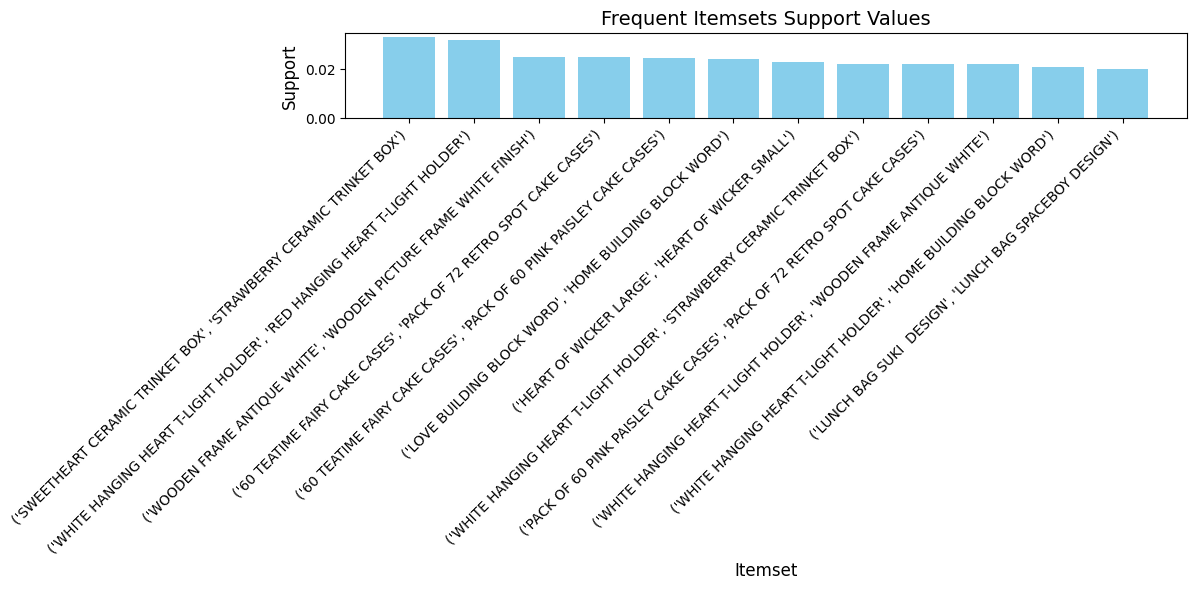

In [165]:
#Display graph
# Sort the results by support for better visualization
sorted_results = results_df.sort_values(by='Support', ascending=False)

# Plot a bar chart
plt.figure(figsize=(12, 6))
plt.bar(sorted_results['Itemset'].astype(str), sorted_results['Support'], color='skyblue')

# Add labels and title
plt.xlabel('Itemset', fontsize=12)
plt.ylabel('Support', fontsize=12)
plt.title('Frequent Itemsets Support Values', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=10)

# Display the graph
plt.tight_layout()
plt.show()